In [7]:
from ipywidgets import IntProgress
from IPython.display import display

In [8]:

%%capture
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
import seaborn as sns
import numpy as np
import torch
!pip install transformers
!pip install umap-learn

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [10]:
cnx = sqlite3.connect('/kaggle/input/croatian-articles2/data(1).db')
df = pd.read_sql_query('SELECT * FROM Article', cnx)
in_category = pd.read_sql_query('SELECT * FROM in_category', cnx)
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df['Content'] = df.Title + ". " + df.Description
#df['Content'] = df['Content'].str.lower()
#df = df.loc[df['Date'].dt.year == 2021]


In [11]:
sample = df.loc[df.articleID == 108269]
sample

articleID  \
108268     108269   

                                                                                                Title  \
108268  Irska ukida gotovo sve korona mjere, ni covid potvrde više nisu obavezne: ‘Ovo je dobar dan!‘   

                                                                                                                                                                                                                                                                                                            Description  \
108268  Irska će vlada u subotu ujutro ukinuti gotovo sve mjere za sprječavanje širenja koronavirusa, objavila je irska televizija RTÉ, a prenosi Jutarnji. To znači da kupci više neće morati pokazivati covid potvrde da bi ušli u razne objekte. Barovima, restoranima i noćnim klubovima također će biti dopušte...   

                                                                                                                                                                                                                                                                                                                                                                                                               Content  \
108268  Irska ukida gotovo sve korona mjere, ni covid potvrde više nisu obavezne: ‘Ovo je dobar dan!‘. Irska će vlada u subotu ujutro ukinuti gotovo sve mjere za sprječavanje širenja koronavirusa, objavila je irska televizija RTÉ, a prenosi Jutarnji. To znači da kupci više neće morati pokazivati covid potvrde da bi ušli u razne objekte. Barovima, restoranima i noćnim klubovima također će biti dopušte...   

                            Date  \
108268 2022-01-21 19:57:59+00:00   

                                                                                                                                                                     Link  \
108268  https://slobodnadalmacija.hr/dubrovnik/vijesti/hrvatska-i-svijet/irska-ukida-gotovo-sve-korona-mjere-ni-covid-potvrde-vise-nisu-obavezne-ovo-je-dobar-dan-1161305   

                                    Hash  
108268  5f539038108fd433e40e99b586ad3fc3

In [12]:
def sample_from_time_interval():
    tDelta = pd.Timedelta("2 days")
    left = df.Date > pd.to_datetime((sample.Date - tDelta).values[0], utc=True)
    right = df.Date <= pd.to_datetime((sample.Date + tDelta).values[0], utc=True)
    mask = left & right
    df_indelta = df.loc[mask].reset_index(drop=True)
    sample_index = df_indelta.index[df_indelta['articleID'] == sample.articleID.values[0]].values[0]
    return df_indelta


df_indelta = sample_from_time_interval()



In [13]:
from transformers import AutoTokenizer, AutoModelForPreTraining

tokenizer = AutoTokenizer.from_pretrained("classla/bcms-bertic")

In [14]:
df_indelta["Title"]
df_indelta["Description"]

def concat_title_description(row):
    return row["Title"]+" [SEP] "+row["Description"]


text_to_process = df_indelta.apply(concat_title_description,axis = 1)
text_to_process.head()


0                                                                                Zaručnički prsten Meghan Fox u obliku srca ima bodlje, njezin zaručnik tvrdi: ‘Ljubav boli!‘  [SEP] Machine Gun Kelly (31) pokazao se veoma kreativnim kada je dizajnirao zaručnički prsten svoje djevojke Megan Fox (35). Slavni rocker je Megan postavio sudbonosno pitanje prošlog utorka sa zaručničkim prstenom koji se sastoji od dva kamena, zelenim i srebrnim, koji karakteriziraju njihova spojena src...
1                                                                               Tajkun na Autobahnu vozio Bugatti 417 km/h i sve snimao! Njemačke vlasti: ‘To je izvan pameti‘  [SEP] Njemačko ministarstvo prometa (BMDV) kritiziralo je cestovnu egzibicijsku vožnju u kojoj je češki tajkun vozio svog Bugatti Chirona javnom autocestom brzinom od 417 kilometara na sat i sve snimio. Video objavljen na internetu ranije ovog mjeseca prikazuje Radima Passera kako vozi svoj hipersportski...
2    Imoćani dobili medicinsku

In [15]:
raw_inputs = text_to_process.values.tolist()

inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors='pt').to(device)

## Output layers

In [16]:
import torch.nn as nn

class CLSEmbeddingLayer(nn.Module):
    def __init__(self):
        super(CLSEmbeddingLayer, self).__init__()
    
    def call(self, outputs):
        hidden_state = outputs[0]
        cls_embeddings = hidden_state[:, 0]
        return cls_embeddings

def triple_pool(outputs):
    attentions = outputs.attentions[-1]

    max_att = attentions.max(dim = 2)[0]
    min_att = attentions.min(dim = 2)[0]
    mean_att = attentions.mean(dim = 2)
    
    return max_att.mean(dim = 1), min_att.mean(dim = 1), mean_att.mean(dim = 1)

def triple_pool2(ouputs):
    attentions = outputs.attentions[-1].mean(dim = 1)
    max_att = attentions.max(dim = 1)[0]
    min_att = attentions.min(dim = 1)[0]
    mean_att = attentions.mean(dim = 1)
    return max_att, min_att, mean_att





    



In [17]:
%%capture
model = AutoModelForPreTraining.from_pretrained("classla/bcms-bertic")
model.to(device)
#print(model)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
BATCH_SIZE = 100
pooled_outputs = []
length = inputs['input_ids'].shape[0]

f = IntProgress(min = 0, max=length // BATCH_SIZE + 1)
display(f)


#print(inputs["input_ids"].shape) outputs: torch.Size([4402, 227])

all_embds_max = torch.zeros(inputs["input_ids"].shape[0],768)
all_embds_min = torch.zeros(inputs["input_ids"].shape[0],768)
all_embds_mean = torch.zeros(inputs["input_ids"].shape[0],768)

for i in range(length // BATCH_SIZE + 1):
    up_to = (i+1)*BATCH_SIZE
    if length < up_to:
        up_to = length
    input_ids = inputs['input_ids'][i*BATCH_SIZE : up_to]
    token_type_ids = inputs['token_type_ids'][i*BATCH_SIZE : up_to]
    attention_mask = inputs['attention_mask'][i*BATCH_SIZE : up_to]
    with torch.no_grad():
        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, output_hidden_states=True,output_attentions = True)
        last_hidden_state = outputs["hidden_states"][-1]
        
        max_att, min_att, mean_att = triple_pool2(outputs)
        
        max_emb = max_att.unsqueeze(-1).expand(last_hidden_state.shape) * last_hidden_state
        min_emb = min_att.unsqueeze(-1).expand(last_hidden_state.shape)* last_hidden_state
        mean_emb = min_att.unsqueeze(-1).expand(last_hidden_state.shape) * last_hidden_state
        
        all_embds_max[i*BATCH_SIZE : up_to] = max_emb.mean(dim = -2)
        all_embds_min[i*BATCH_SIZE : up_to] = min_emb.mean(dim = -2)
        all_embds_mean[i*BATCH_SIZE : up_to] = mean_emb.mean(dim = -2)
        
    
    #print(max_emb.shape) outputs: torch.Size([100, 227])
    #print(input_ids.shape) outputs: torch.Size([100, 227])
    #print(outputs.keys()) outputs: odict_keys(['logits', 'hidden_states', 'attentions'])
    #print(outputs.attentions[0].shape) outputs: torch.Size([100, 12, 227, 227]) 
    
    f.value += 1

IntProgress(value=0, max=45)

In [19]:
from sklearn.decomposition import PCA
import numpy as np


pca = PCA(n_components=2)
embds_pca_max = pca.fit_transform(all_embds_max.numpy())

pca = PCA(n_components=2)
embds_pca_min = pca.fit_transform(all_embds_min.numpy())

pca = PCA(n_components=2)
embds_pca_mean= pca.fit_transform(all_embds_mean.numpy())




In [20]:
%%capture
!pip install sentence_transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
from sentence_transformers import util

def get_example_neighs(example_idx,embds):
    cos_sim = util.cos_sim(embds,embds)
    example_neighs = cos_sim.numpy()[example_idx]
    indices = np.argsort(example_neighs)[-6:-1]
    indices = list(reversed(indices))
    indices.insert(0,example_idx)
    
    out_df = pd.DataFrame()
    out_df["Article"] = [text_to_process[idx] for idx in indices]
    out_df["Cosine Similarity"] = example_neighs[indices]
    
    return out_df

In [26]:
example_idx = 650

get_example_neighs(example_idx,all_embds_max)



Article  \
0                                                                                                                                                                                                     Preminuo pukovnik Kranzer iz "Bitke na Neretvi" [SEP] Hardy Krüger, njemački glumac sa zavidnom holivudskom karijerom i ulogom u jugoslavenskom ratnom spektaklu "Bitka na Neretvi", umro je u 93. godini u Kaliforniji, objavio je njegov agent.   
1                                                                                                                                                                                   Umro glumac Hardy Krüger, pukovnik Kranzer iz “Bitke na Neretvi” [SEP] Hardy Krüger, njemački glumac sa zavidnom holivudskom karijerom i ulogom u jugoslavenskom ratnom spektaklu "Bitka na Neretvi", umro je u 93. godini u Kaliforniji, objavio je njegov agent.    
2                                                                                                                                                                                                                         Uhitili muškarca koji je iz čista mira ubio studenticu u trgovini [SEP]  Kalifornijska policija uhitila je muškarca koji je u nasumičnom napadu ubio studenticu Briannu Kupfer u luksuznoj trgovini namještaja u Los Angelesu   
3                                    Potjera u turističkom raju: Kanađanin pucao u trojicu sunarodnjaka, dvojicu ubio pa pobjegao  [SEP] Dvojica Kanađana su ubijena, a jedan je ranjen u pucnjavi u hotelskom kompleksu blizu Cancuna, priopćile su u petak meksičke vlasti. Napad se dogodio u hotelskom kompleksu Xcaret kada je kanadski državljanin pucao u svoje tri žrtve. Za osumnjičenim ubojicom, gostom u hotelu, pokrenuta je potjera, a...   
4  Tragedija u Kamerunu: najmanje 16 mrtvih u stampedu nakon požara u diskoteci. Za sve je krivo neoprezno rukovanje pirotehnikom [SEP] Najmanje je 16 ljudi poginulo u požaru u noćnome klubu u luksuznoj četvrti kamerunskog glavnog grada Yaoundéa, koji je u noći na nedjelju slučajno izazvao vatromet. Tragedija se dogodila u vrijeme dok je Kamerun domaćin Afričkoga kupa nacija (ACN), kontinentalnog nogometnog prvenstva. "Požar je izbi...   
5                    Poznatu tursku novinarku privelo u dva sata poslije ponoći zbog oštrog komentara protiv predsjedničkog ureda [SEP] Turski sud je poznatoj novinarki Sedef Kabas u subotu odredio pritvor pod optužbom da je uvrijedila turskog predsjednika Recepa Tayyipa Erdogana i time prekršila zakon prema kojemu su dosad procesuirani deseci tisuća ljudi, objavio je turski CNN. Policija je Kabasu privela oko dva sata poslije ponoć...   

   Cosine Similarity  
0           1.000000  
1           0.994516  
2           0.991604  
3           0.991054  
4           0.990934  
5           0.990878

In [23]:
from sklearn.manifold import TSNE
embds_tsne_max = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(all_embds_max.numpy())
embds_tsne_min = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(all_embds_min.numpy())
embds_tsne_mean = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(all_embds_mean.numpy())


KeyboardInterrupt: 

In [ ]:
import umap.umap_ as umap
embds_umap_max = umap.UMAP().fit_transform(all_embds_max)
embds_umap_min = umap.UMAP().fit_transform(all_embds_min)
embds_umap_mean = umap.UMAP().fit_transform(all_embds_mean)



In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()


def visualize_embds(embds2d):
    fig = figure(width = 720,height = 720,title = "PCA",tooltips = "@data")

    pooled_outputs_pca_df = pd.DataFrame(embds2d)
    pooled_outputs_pca_df.columns = ["x","y"]
    pooled_outputs_pca_df["data"] = text_to_process

    fig.scatter("x","y",source = pooled_outputs_pca_df)
    show(fig)
    return

In [45]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def generate_metrics(X, max_clusters,name):
    range_n_clusters = range(2, max_clusters)
    silhouette_scores = list()
    davis_bouldin_scores = list()
    labels_per_cluster_num = dict()
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(X)
        results = kmeans.predict(X)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
        davis_bouldin_scores.append(davies_bouldin_score(X.numpy(), kmeans.labels_))
        labels_per_cluster_num[n_clusters] = kmeans.labels_

    plt.plot(range_n_clusters, silhouette_scores, '-o', label='Silhouette score')
    plt.title("BERTić:"+" "+name)
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette score")
    #plt.savefig(name + '_sil.png', bbox_inches='tight')
    plt.show()
    
    plt.plot(range_n_clusters, davis_bouldin_scores, '-o', label='Davis-Bouldin score')
    plt.title("BERTić:"+" "+name)
    plt.xlabel("Number of clusters")
    plt.ylabel("Davies-Bouldin score")
    #plt.savefig(name + '_db.png', bbox_inches='tight')
    plt.show()
    return labels_per_cluster_num

In [60]:
from sklearn.decomposition import PCA
from bokeh.plotting import figure, show
from bokeh.palettes import Category20_20 as palette
from bokeh.io import output_notebook
import itertools
import umap
from sklearn.manifold import TSNE


def generate_visuals(X, labels_per_cluster_num, chosen_cluster_num):
  # Call once to configure Bokeh to display plots inline in the notebook.
    output_notebook()
    df_subset = pd.DataFrame()
    df_subset['cluster'] = labels_per_cluster_num[chosen_cluster_num]

    #PCA
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(X)

    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    df_subset['x0_pca'] = x0
    df_subset['x1_pca'] = x1

    colors = itertools.cycle(palette)
    p = figure(plot_width=600, plot_height=450, title = "PCA", tooltips="@Title")
    for i in range(chosen_cluster_num):
        p.scatter('x0_pca', 'x1_pca', source=df_subset[df_subset['cluster'] == i], color = next(colors), legend_label=f'Category {i}')
    show(p)

    #TSNE
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
    tsne_vecs = tsne.fit_transform(X)

    x0 = tsne_vecs[:, 0]
    x1 = tsne_vecs[:, 1]

    df_subset['x0_tsne'] = x0
    df_subset['x1_tsne'] = x1

    colors = itertools.cycle(palette)
    p = figure(plot_width=600, plot_height=450, title = "TSNE", tooltips="@Title")
    for i in range(chosen_cluster_num):
        p.scatter('x0_tsne', 'x1_tsne', source=df_subset[df_subset['cluster'] == i], color = next(colors), legend_label=f'Category {i}')
    show(p)

    #UMAP
    reducer = umap.UMAP()
    umap_vecs = reducer.fit_transform(X)

    x0 = umap_vecs[:, 0]
    x1 = umap_vecs[:, 1]

    df_subset['x0_umap'] = x0
    df_subset['x1_umap'] = x1

    colors = itertools.cycle(palette)
    p = figure(plot_width=600, plot_height=450, title = "UMAP", tooltips="@Title")
    for i in range(chosen_cluster_num):
        p.scatter('x0_umap', 'x1_umap', source=df_subset[df_subset['cluster'] == i], color = next(colors))
    show(p)

In [ ]:
def get_text_neighs(idx,):
    return

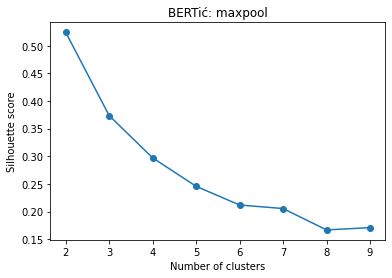

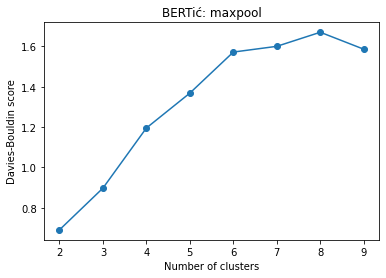

In [50]:
out_metrics = generate_metrics(all_embds_max,10,"max"+"pool")


In [61]:
generate_visuals(all_embds_mean,out_metrics, 7)

Loading BokehJS ...

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
visualize_embds(embds_pca_min)


In [24]:
visualize_embds(embds_pca_mean)


In [26]:
visualize_embds(embds_tsne_max)

In [ ]:
visualize_embds(embds_tsne_min)


In [ ]:
visualize_embds(embds_tsne_mean)


In [ ]:
visualize_embds(embds_umap_max)


In [ ]:
visualize_embds(embds_umap_min)


In [ ]:
visualize_embds(embds_umap_mean)
